In [1]:
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy import constants as c
import astropy.units as u
import multiprocessing
import time

In [2]:
h=cosmo.H0.value/100
fac = c.c**2 / (4 * np.pi * c.G)
fac = fac.to(u.Msun * u.pc**(-2)*u.Mpc).value
comoving = True


Mpc_step = 0.3
binsnum = 8 # one side
Mpc_range = Mpc_step * (binsnum-1/2)  # center +- Mpc_range
delta = 1.5 * Mpc_range # pre-selection


xbins = np.linspace(-Mpc_range, Mpc_range, 2 * binsnum)
ybins = np.linspace(-Mpc_range, Mpc_range, 2 * binsnum)

In [3]:

# UNIONS data
data = fits.open('/data/cjia/cluster/unions_shapepipe_2022_v1.3.fits')[1].data
ra = data['RA']
dec = data['Dec']
e1 = -data['e1']
e2 = data['e2']
w = data['w']


'''
# DECaLs data
data = fits.open('/data/cjia/cluster/decals_shape_lensfit.fits')[1].data
ra = data['ra']
dec = data['dec']
e1 = data['e1']
e2 = -data['e2']
w = data['wt']
z = data['z']
'''

'''
# SDSS data
sourcedata = Table.from_pandas(pd.read_csv('/data/cjia/cluster/sourcewmap3',delim_whitespace=True,names=['ra','dec','e1','e2','res','er1','er2','zs','ds','spa']))
ra = sourcedata['ra']
dec = sourcedata['dec']
e1 = sourcedata['e1']
e2 = sourcedata['e2']
w = 1 / (1 + sourcedata['er1']**2 + sourcedata['er2']**2)
'''

"\n# SDSS data\nsourcedata = Table.from_pandas(pd.read_csv('/data/cjia/cluster/sourcewmap3',delim_whitespace=True,names=['ra','dec','e1','e2','res','er1','er2','zs','ds','spa']))\nra = sourcedata['ra']\ndec = sourcedata['dec']\ne1 = sourcedata['e1']\ne2 = sourcedata['e2']\nw = 1 / (1 + sourcedata['er1']**2 + sourcedata['er2']**2)\n"

In [4]:
def pre_select(rac, decc, delta):
    premask = (ra < rac + delta / np.cos(decc / 180 * np.pi)) * (ra > rac - delta / np.cos(decc / 180 * np.pi)) * (dec < decc + delta) * (dec > decc - delta)
    rasub = ra[premask]
    decsub = dec[premask]
    e1sub = e1[premask]
    e2sub = e2[premask]
    wsub = w[premask]
    return [rasub, decsub, e1sub, e2sub, wsub]

In [5]:
def extract_grid_member(ra, dec, e1, e2, w, rac, decc, z, phi):   # extract_grid_member
    dx = (ra - rac) * np.cos(decc / 180 * np.pi)  # degree
    dy = dec - decc                               # degree
    
    scale_d2Mpc = cosmo.angular_diameter_distance(z).value * h / 180 * np.pi
    scale_Mpc2d = 1 / scale_d2Mpc
    
    d_range = Mpc_range * scale_Mpc2d
    d_step = Mpc_step * scale_Mpc2d
    
    grid_list = []
    
    for i in range(len(xbins)):
        for j in range(len(ybins)):
            x1 = xbins[i] - Mpc_step
            x2 = xbins[i] + Mpc_step
            y1 = ybins[j] - Mpc_step
            y2 = ybins[j] + Mpc_step
            
            if (270 < phi <= 360) or (0 <= phi < 90):
                mask = (dy < np.tan(phi / 180 * np.pi) * dx - x1 / np.cos(phi / 180 * np.pi))
                mask = mask * (dy > np.tan(phi / 180 * np.pi) * dx - x2 / np.cos(phi / 180 * np.pi))
                mask = mask * (dx > -np.tan(phi / 180 * np.pi) * dy + y1 / np.cos(phi / 180 * np.pi))
                mask = mask * (dx < -np.tan(phi / 180 * np.pi) * dy + y2 / np.cos(phi / 180 * np.pi))
            elif (90 < phi < 270):
                mask = (dy > np.tan(phi / 180 * np.pi) * dx - x1 / np.cos(phi / 180 * np.pi))
                mask = mask * (dy < np.tan(phi / 180 * np.pi) * dx - x2 / np.cos(phi / 180 * np.pi))
                mask = mask * (dx < -np.tan(phi / 180 * np.pi) * dy + y1 / np.cos(phi / 180 * np.pi))
                mask = mask * (dx > -np.tan(phi / 180 * np.pi) * dy + y2 / np.cos(phi / 180 * np.pi))
            elif phi == 90:
                mask = (dx > x1) * (dx < x2) * (dy > y1) * (dy < y2)
            else:
                mask = (dx < -x1) * (dx > -x2) * (dy < -y1) * (dy > -y2)
            
            e1_grid = e1[mask]
            e2_grid = e2[mask]
            w_grid = w[mask]
            grid_list.append([xbins[i], ybins[j], e1_grid, e2_grid, w_grid, phi])
    
    return grid_list
# return [] for each grid


def get_grid_info():
    dxflat, dyflat, e1flat, e2flat, wflat, phiflat = [], [], [], [], [], []
    for k in range(len(zlist)):
        rac = raclist[k]
        decc = decclist[k]
        z_l = zlist[k]
        phi = philist[k]
        preselect = pre_select(rac, decc, delta)
        rasub = preselect[0]
        decsub = preselect[1]
        e1sub = preselect[2]
        e2sub = preselect[3]
        wsub = preselect[4]
        
        grid_list = extract_grid_member(rasub, decsub, e1sub, e2sub, wsub, rac, decc, z_l, phi)
        
        for i in range(len(grid_list)):
            for j in range(len(grid_list[i][2])): # length of e1_grid
                dxflat.append(grid_list[i][0])
                dyflat.append(grid_list[i][1])
                e1flat.append(grid_list[i][2][j])
                e2flat.append(grid_list[i][3][j])
                wflat.append(grid_list[i][4][j])
                phiflat.append(grid_list[i][5])
    
    return [dxflat, dyflat, e1flat, e2flat, wflat, phiflat]

In [6]:
def grid_shear_stack(dx, dy):
    mask = (dx == DX) * (dy == DY)
    e1grid = E1[mask]
    e2grid = E2[mask]
    wgrid = W[mask]
    phigrid = PHI[mask]
    num = len(e1grid)
    
    thetagrid = - 2 * phigrid
    e1rot = np.cos(thetagrid / 180 * np.pi) * e1grid - np.sin(thetagrid / 180 * np.pi) * e2grid
    e2rot = np.sin(thetagrid / 180 * np.pi) * e1grid + np.cos(thetagrid / 180 * np.pi) * e2grid
    
    g1 = np.sum(e1rot * wgrid) / np.sum(wgrid)
    g2 = np.sum(e2rot * wgrid) / np.sum(wgrid)
    
    a = 0   # ?
    sigmasq = 1/wgrid - a**2
    gerr = 1/2 * np.sum(sigmasq * wgrid**2) / np.sum(wgrid)**2
    
    return [dx, dy, g1, g2, gerr, num]   ############ gerr means sigma**2

In [13]:
# input
#mode = 'bcg_major'
#mode = 'rotation'
mode = 'satellite_major'
input_data = np.loadtxt(f'input_{mode}', unpack=True)
raclist = input_data[0]
decclist = input_data[1]
zlist = input_data[2]
philist = input_data[3]

DATA = get_grid_info()
DX = np.array(DATA[0])
DY = np.array(DATA[1])
E1 = np.array(DATA[2])
E2 = np.array(DATA[3])
W = np.array(DATA[4])
PHI = np.array(DATA[5])

result = []
for i in range(len(xbins)):
    calculation = multiprocessing.Pool(processes=len(ybins))
    for j in range(len(ybins)):
        calculation.apply_async(grid_shear_stack, (xbins[i], ybins[j],), callback=result.append)
            
    calculation.close()
    calculation.join()

In [14]:
f = open(f'stack_{mode}.txt', 'w+')
print('# dx dy g1 g2 gerr**2 num', file=f)
for k in range(len(result)):
    row = result[k]
    print(row[0], row[1], row[2], row[3], row[4], row[5], file=f)
f.close()

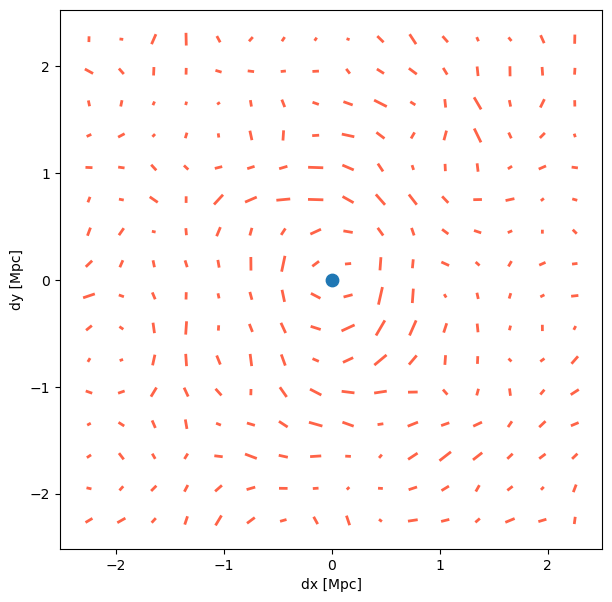

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import numpy as np


data = np.loadtxt(f'stack_{mode}.txt', unpack=True)
dx = data[0]
dy = data[1]
g1 = data[2]
g2 = data[3]




def get_xy(g1, g2):
    x = 1
    if g1 == 0:
        if g2 > 0:
            y = 1
        elif g2 < 0:
            y = -1
        else:
            return [0, 0]
    elif g1 > 0:
        y = np.tan(np.arctan(g2/g1) / 2)
    else:
        y = - 1 / np.tan(np.arctan(g2/g1) / 2)
    
    scale = np.sqrt(g1**2 + g2**2) / np.sqrt(x**2 + y**2)
    x = x * scale
    y = y * scale
    
    return [x, y]



plt.figure(figsize=(7, 7))

for k in range(len(dx)):
    xy = get_xy(g1[k], g2[k])
    #plotscale = 1.3
    plotscale = 30
    x = xy[0] * plotscale
    y = xy[1] * plotscale
    plotx = [dx[k] - x, dx[k] + x]
    ploty = [dy[k] - y, dy[k] + y]
    plt.plot(plotx, ploty, c='tomato', linewidth=2)


plt.scatter(0, 0, s=80)
plt.xlabel('dx [Mpc]')
plt.ylabel('dy [Mpc]')
plt.savefig(f'stack_{mode}.png')
plt.show()
plt.clf()
